In [1]:
import os
import sys

import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch import nn
from torch.nn import functional as F
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import networkx as nx
import numpy as np

from models import CustomGCNConv
import utils

In [2]:
# Read the training graphs
filenames = os.listdir('init_node_embedding_train_graphs')
train_graphs = []
for filename in filenames:
    file_path = os.path.join('init_node_embedding_train_graphs', filename)
    g = nx.read_edgelist(file_path, nodetype=int, create_using=nx.DiGraph)
    # Set the edge weight to 1/in_degree
    for u, v, a in g.edges(data=True):
        a['weight'] = 1 / len(list(g.predecessors(v)))
    train_graphs.append(g)

# Construct training data
num_features = 64
device = torch.device('cuda')
data_list = []
# Select different initial vectors and edge_index for x according to the different graphs
with tqdm(total=len(train_graphs), desc='Generate training data', file=sys.stdout) as bar:
    for i, graph in enumerate(train_graphs):
        graph_edge_index, graph_edge_weight = utils.get_graph_edge_index(graph, True)
        y_g = np.zeros(graph.number_of_nodes(), dtype=float)
        for node in graph.nodes():
            y_g[node] = utils.computeMC(graph, [node], 10000) / graph.number_of_nodes()

        y = y_g
        y = (y - y.min()) / (y.max() - y.min())
        
        y = torch.tensor(y, dtype=torch.float)
        x = torch.ones(graph.number_of_nodes(), num_features * 2, dtype=torch.float)
        edge_index = torch.tensor(graph_edge_index, dtype=torch.long)
        edge_weight = torch.tensor(graph_edge_weight, dtype=torch.float)
        data = Data(x, edge_index, y=y, edge_weight=edge_weight).to(device)
        data_list.append(data)
        bar.update(1)

生成训练数据中: 100%|██████████| 50/50 [05:03<00:00,  6.06s/it]


In [3]:
class NodeEncoder(nn.Module):
    def __init__(self, num_features, T=3):
        super(NodeEncoder, self).__init__()
        self.convs1 = nn.Sequential()
        self.convs2 = nn.Sequential()
        for i in range(T):
            self.convs1.add_module(f'conv_1_{i}', CustomGCNConv(num_features, num_features))
            self.convs2.add_module(f'conv_2_{i}', CustomGCNConv(num_features, num_features))
        self.w1 = nn.Linear(num_features, num_features, bias=False)
        self.w2 = nn.Linear(num_features, num_features, bias=False)
        self.fc1 = nn.Linear(2 * num_features, 2 * num_features)
        self.fc2 = nn.Linear(2 * num_features, 1)

    def forward(self, x, edge_index, edge_weight):
        x1 = x[:, x.shape[1]//2:]
        x2 = x[:, :x.shape[1]//2]
        for i, (conv1, conv2) in enumerate(zip(self.convs1, self.convs2)):
            x1 = F.leaky_relu(conv1(x1, edge_index[[1, 0]], edge_weight, 0.0 if i == 0 else 1.0), 0.2)
            x2 = F.leaky_relu(conv1(x2, edge_index, edge_weight, 0.0 if i == 0 else 1.0), 0.2)
        x = self.fc1(torch.cat([self.w1(x1), self.w2(x2)], dim=-1))
        y = x
        x = F.leaky_relu(self.fc2(x), 0.2).view(-1)
        return x, y

In [24]:
lr = 0.001
num_epochs = 20
batch_size = 16
train_iter = DataLoader(data_list, batch_size=batch_size, shuffle=True)
model = NodeEncoder(num_features=num_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# train
loss_list = []
for epoch in range(num_epochs):
    for data in train_iter:
        # print(type(data.y))
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_weight)[0]
        loss = F.mse_loss(out, data.y)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    # print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

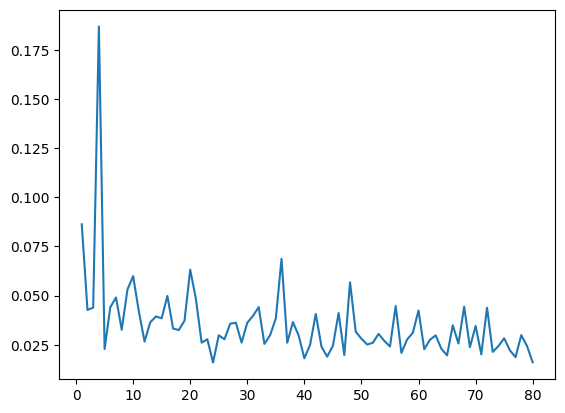

In [25]:
# Draw a loss change chart
plt.plot(range(1, len(loss_list)+1), loss_list)
plt.show()

In [26]:
torch.save(model.state_dict(), 'node_encoder.pth')